In [453]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [30]:
data = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\Q01_HL_23.csv", skiprows=[0,1,2, 3],
                   names = ["date"," Hl-Vega-OK", "Hl-US-Odlehc", "Hladina KDO", "Teplota KDO", 
                                       "Rychlost KDO", "Prietok_l", "Napatie_AKU2", "Napatie_AKU",  "Prietok"],
                  sep = ";", decimal=',')

In [79]:
rain = pd.read_csv("d:\moje_dokumenty\Desktop\matfyz\mgr\semester 11\Projektovy seminar\SR02_H2_27374.csv", skiprows=[0,1,2, 3],
                  usecols = [0,1], names = ["date","rain"],
                  sep = ";", decimal=',')

In [96]:
data["date"] = pd.to_datetime(data['date'], format='%d.%m.%Y %H:%M:%S')
rain["date"] = pd.to_datetime(rain['date'], format='%d.%m.%Y %H:%M:%S')
rain.replace(r'^\s*$', np.nan, regex=True, inplace=True)
rain["rain"] = pd.to_numeric(rain["rain"].str.replace(',', '.') )

In [104]:
rain.set_index('date', inplace=True)

# Resample data to two-minute intervals and calculate the sum for each two-minute period
rain['rain_2m'] = rain['rain'].resample('2T').sum()

# Assign NaN to odd minutes
rain['rain_2m'][rain.index.minute % 2 != 0] = np.nan

In [ ]:
rain["date"] = rain.index

In [128]:
print(rain['date'].diff().dropna().min())
print(rain['date'].diff().dropna().max())
print(rain['date'].diff().dropna().value_counts())

0 days 00:01:00
0 days 00:10:00
0 days 00:10:00    4155
0 days 00:01:00    2496
0 days 00:04:00      20
0 days 00:07:00      16
0 days 00:06:00      16
0 days 00:02:00      14
0 days 00:09:00      14
0 days 00:03:00      13
0 days 00:08:00       9
0 days 00:05:00       8
Name: date, dtype: int64


In [129]:
print(data['date'].diff().dropna().min())
print(data['date'].diff().dropna().max())
print(data['date'].diff().dropna().value_counts())

0 days 00:02:00
0 days 00:04:00
0 days 00:02:00    22317
0 days 00:04:00        1
Name: date, dtype: int64


In [111]:
sum(data['date'].dt.minute % 2 != 0)

0

In [114]:
rain.index = range(rain.shape[0])

In [115]:
rain.head(10)

,rain,rain_2m,date
0,0.0,NaN,2022-05-31 23:01:00
1,0.1,0.1,2022-05-31 23:02:00
2,0.0,NaN,2022-05-31 23:03:00
3,0.0,0.0,2022-05-31 23:04:00
4,0.0,NaN,2022-05-31 23:05:00
5,0.1,0.1,2022-05-31 23:06:00
6,0.0,NaN,2022-05-31 23:07:00
7,0.0,0.0,2022-05-31 23:08:00
8,0.0,NaN,2022-05-31 23:09:00
9,0.0,0.1,2022-05-31 23:10:00


In [117]:
data = data.merge(rain, on='date', how='left')

In [123]:
data.head()

,date,Hl-Vega-OK,Hl-US-Odlehc,Hladina KDO,Teplota KDO,Rychlost KDO,Prietok_l,Napatie_AKU2,Napatie_AKU,Prietok,Moving_Average,day,week,Centered_Moving_Average,rain,rain_2m
0,2022-05-31 23:02:00,349,,320,14,0.56,114.6,,,13.75,NaN,2022-05-31,2022-22,NaN,0.1,0.1
1,2022-05-31 23:04:00,349,,319,14,0.51,102.3,,,12.28,NaN,2022-05-31,2022-22,NaN,0.0,0.0
2,2022-05-31 23:06:00,352,,320,14,0.49,98.9,,,11.87,NaN,2022-05-31,2022-22,NaN,0.1,0.1
3,2022-05-31 23:08:00,352,,322,14,0.49,99.4,,,11.93,NaN,2022-05-31,2022-22,NaN,0.0,0.0
4,2022-05-31 23:10:00,353,,325,14,0.50,101.6,,,12.19,NaN,2022-05-31,2022-22,NaN,0.0,0.1


In [124]:
data.describe()

,Hl-Vega-OK,Hladina KDO,Teplota KDO,Rychlost KDO,Prietok_l,Prietok,Moving_Average,Centered_Moving_Average,rain,rain_2m
count,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22319.000000,22290.000000,22290.000000,1304.000000,5484.000000
mean,185.552310,192.835476,15.688517,0.263786,29.987177,3.598630,3.593053,3.593053,0.050613,0.023359
std,77.118763,91.678332,0.995117,0.113476,34.873107,4.185152,3.861838,3.861838,0.132684,0.128841
min,0.000000,100.000000,13.000000,-0.090000,0.000000,0.000000,0.030333,0.030333,0.000000,0.000000
25%,157.000000,139.000000,15.000000,0.160000,12.800000,1.540000,1.590417,1.590417,0.000000,0.000000
50%,170.000000,180.000000,16.000000,0.270000,21.000000,2.520000,2.686333,2.686333,0.000000,0.000000
75%,182.000000,221.000000,16.000000,0.350000,34.100000,4.090000,4.148917,4.148917,0.100000,0.000000
max,794.000000,970.000000,19.000000,0.800000,326.300000,39.150000,32.118667,32.118667,1.700000,3.300000


In [125]:
rain.describe()

,rain,rain_2m
count,2581.000000,5485.000000
mean,0.050794,0.023355
std,0.133948,0.128830
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.100000,0.000000
max,1.700000,3.300000


In [120]:
data.shape

(22319, 16)

In [121]:
rain.shape

(6762, 3)

In [122]:
data.isna().sum()

date                           0
 Hl-Vega-OK                    0
Hl-US-Odlehc                   0
Hladina KDO                    0
Teplota KDO                    0
Rychlost KDO                   0
Prietok_l                      0
Napatie_AKU2                   0
Napatie_AKU                    0
Prietok                        0
Moving_Average                29
day                            0
week                           0
Centered_Moving_Average       29
rain                       21015
rain_2m                    16835
dtype: int64

In [141]:
sum(data["Prietok"] == 0)

128

In [554]:
class TS_Class:
    
    def __init__(self, data, main_var = "Prietok", 
                 start_date = None, end_date = None, periodicity = "2T", check_per = True):
        if start_date is None:
            start_date = data["date"].min()
        if end_date is None:
            end_date = data["date"].max()
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        self.data = df.merge(data, on='date', how='left')   # ensuring we have constant periodicity in observations
        if not check_per:
            self.data = data
        self.main_var = main_var
        self.data[main_var + "_diff_1"] = data[main_var].diff()
        self.models = {}
        
    def get_period_data(self, period, start_time = None, which = 1, subset = None):
        """Period is either 'daily', 'weekly', or whole number indicating number of hours."""
        used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
        if type(period) == int:
            if start_time is None or start_time == "start":
                reference_point = used_data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = used_data[used_data['date'].dt.time == start_time.time()]["date"].min()
                used_data = used_data[used_data["date"]>= reference_point]    # cut off observations before start_time
            used_data["period_index"] = used_data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            used_data["period_name"] = used_data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            used_data['period_name'] = used_data['date'].dt.date
            
        elif period == "weekly":
            first = used_data['date'].dt.strftime('%Y-%W').apply(
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )
            used_data['period_name'] = first.apply(
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. "weekly" or "daily" are expected.')
        
        if which == 1:
            self.period_data = used_data.groupby('period_name')
        else:
            self.period_data_2 = used_data.groupby('period_name')
        
    def get_y_lim(self, value, negative = False):
        if negative:
            value = - value
        if value < 5: return 5
        if value < 10: return 10
        if value < 20: return 20
        return value*1.1
    
    def get_measures(self, variable, include, window, which = 1):   
        suff = "" if which == 1 else "_2"
        if "CMA" in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
        if "CeMA_bounds" in include:
            self.data['Centered_Moving_Average'+suff] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['Centered_Moving_SD'+suff] = self.data[variable].rolling(window=window, center=True).std()
            self.data['CMA_upper'+suff] = self.data['Centered_Moving_Average'+suff] + self.data['Centered_Moving_SD'+suff]
            self.data['CMA_lower'+suff] = self.data['Centered_Moving_Average'+suff] - self.data['Centered_Moving_SD'+suff]
        
        if "MoA" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
        if "MovA_bounds" in include:
            self.data['Moving_Average'+suff] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['Moving_SD'+suff] = self.data[variable].rolling(window=window, center=False).std()
            self.data['MA_upper'+suff] = self.data['Moving_Average'+suff] + self.data['Moving_SD'+suff]
            self.data['MA_lower'+suff] = self.data['Moving_Average'+suff] - self.data['Moving_SD'+suff]
    
    def get_ax(self, ax, group_data, unit, variable, include, rain_lims, which):  
        suff = "" if which == 1 else "_2"
        ax.plot(group_data['date'], group_data[variable], label = variable)
        if "CMA" in include:
            ax.plot(group_data['date'], group_data['Centered_Moving_Average'+suff], color="red", label = "CMA")
        if "CeMA_bounds" in include:
            ax.plot(group_data['date'], group_data['CMA_upper'+suff], color="orange", label = "CMA_Up")
            ax.plot(group_data['date'], group_data['CMA_lower'+suff], color="orange", label = "CMA_L")
        if "MoA" in include:
            ax.plot(group_data['date'], group_data['Moving_Average'+suff], color="red", label = "MA")
        if "MovA_bounds" in include:
            ax.plot(group_data['date'], group_data['MA_upper'+suff], color="orange", label = "MA_Up")
            ax.plot(group_data['date'], group_data['MA_lower'+suff], color="orange", label = "MA_L")
        ax.set_title(f'Time Series for {unit}')
        ax.set_xlabel('Date and Time')
        ax.set_ylabel(variable)
        ax.legend(loc="upper left")
        ylim_up = self.get_y_lim(group_data[variable].max())
        ylim_down = -self.get_y_lim(group_data[variable].min(), True) if group_data[variable].min() < 0 else 0
        ax.set_ylim(ylim_down, ylim_up)
            
        ax2 = ax.twinx()
        ax2.set_ylim(*rain_lims)
        ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
        ax2.invert_yaxis()
        ax2.set_ylabel('rain (Upside-Down)', color='green')
        ax2.tick_params(axis='y', labelcolor='green')
        ax2.legend(loc='upper right')
            
        return (ax, ax2)
        
    def plot(self, variable = None, period = "all", start_time = None, subset = None,
             include = ("CMA", "CeMA_bounds"), window = 30, rain_lims = (0,5), fig_size = None,
            variable_2 = None, start_time_2 = None, include_2 = ("CMA", "CeMA_bounds"), window_2 = 30,
            double_plot = False):
        if variable is None:
            variable = self.main_var
        
        self.get_measures(variable, include, window, which = 1)
        if start_time_2 is not None:
            if variable_2 is None: variable_2 = variable
            self.get_measures(variable_2, include_2, window_2, which = 2)
                
        if period == "all":
            self.data["const"] = "whole data"
            used_data = self.data.copy() if subset is None else self.data.iloc[subset,].copy()
            self.period_data = used_data.groupby("const")
        else:
            self.get_period_data(period, start_time, 1, subset)
        
        if start_time_2 is None:
            self.period_data_2 = self.period_data
        else:
            self.get_period_data(period, start_time_2, 2, subset)
            
        for grouped_1, grouped_2 in zip(self.period_data,self.period_data_2):
            unit_1, group_data_1 = grouped_1
            unit_2, group_data_2 = grouped_2
            
            if double_plot:
                group_data_1[variable].plot(xlabel = 'Date and Time', ylabel = variable, label = variable)
                group_data_2[variable_2].plot(label = variable_2)
                
                plt.title(f'Time Series for {unit_1}')
                plt.legend(loc="upper left")
                plt.show()
                continue
            
            if start_time_2 is not None:
                if fig_size is None: 
                    fig_size = (19, 6)
                fig, ax = plt.subplots(1, 2, figsize=fig_size)
                ax[0], axb1 = self.get_ax(ax[0], group_data_1, unit_1, variable, include, rain_lims, 1)
                ax[1], axb2 = self.get_ax(ax[1], group_data_2, unit_2, variable_2, include_2, rain_lims, 2)
            else:
                if fig_size is None: 
                    fig_size = (10, 6)
                fig, ax = plt.subplots(figsize=fig_size)
                ax, axb1 = self.get_ax(ax, group_data_1, unit_1, variable, include, rain_lims, 1)
            plt.grid(True)
            plt.show()
            
        
    def get_ETS(self, variable, model_name, groupby = None, show_progress = False,
                error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=720):
        """Note: there is 720 observations per day, for 1 day periodicity we need 720 seasonal components, which is too 
        many for practical estimatation - careful about seasonal components."""
        self.data[model_name + "_fitted"] = np.nan
        self.models[model_name] = []
        i = -1
        if groupby is None:
            self.data["const"] = "whole data"
            grouped = self.data.groupby("const")
        else:
            if groupby == "daily":
                self.data['period_name'] = self.data['date'].dt.date
                grouped = self.data.groupby("period_name")
            elif groupby == "weekly":
                self.data['period_name'] = self.data['date'].dt.strftime('%Y-%W')
                grouped = self.data.groupby("period_name")
            else:
                grouped = self.data.groupby(groupby)
                
        length = len(grouped)
        for unit, grouped_data in grouped:
            model = ETSModel(grouped_data[variable], error=error, trend=trend, seasonal=seasonal, 
                                            damped_trend=damped_trend, seasonal_periods=seasonal_periods)
            result = model.fit()
            grouped_data[model_name + "_fitted"] = result.fittedvalues
            self.models[model_name].append((unit, model))
            self.data.loc[grouped_data.index,model_name + "_fitted"] = grouped_data[model_name + "_fitted"]
            if show_progress:
                i += 1
                if i%5 == 0:
                    print(f"{i+1} out of {length}")

In [555]:
ts_data = TS_Class(data)

In [ ]:
ts_data.plot(include=("CeMA_bounds"), period=12, start_time="0:00:00", start_time_2="6:00:00", include_2 = ("CeMA_bounds"))

In [ ]:
ts_data.plot(variable = "Prietok_diff_1",include=("CeMA_bounds"), period=12, 
             start_time="0:00:00", start_time_2="6:00:00", include_2 = ("CeMA_bounds"))

In [ ]:
ts_data.plot(include=("CeMA_bounds"), period=12, variable_2 = "Prietok_diff_1",
             start_time_2="start", include_2 = ("CeMA_bounds"))

In [ ]:
ts_data.get_ETS("Prietok", "ETS_AAN", groupby = None, show_progress = True, seasonal = None)

In [ ]:
ts_data.plot(include=("CeMA_bounds"), period=12, variable_2 = "ETS_AAN_fitted",
             start_time_2="start", include_2 = ("CeMA_bounds"))

In [ ]:
ts_data.plot(include=("CeMA_bounds"), period=12, variable_2 = "ETS_AAN_fitted",
             start_time_2="start", double_plot = True)

In [ ]:
ts_data.plot(subset=list(range(200))+list(range(5000,5200)))

In [ ]:
ts_data.plot(variable = "Prietok_diff_1",include=("CeMA_bounds"), period="weekly", subset=list(range(200))+list(range(15000,15200)))

# trash bin

In [65]:
window_size = 30
data['Moving_Average'] = data['Prietok'].rolling(window=window_size).mean()
data['Centered_Moving_Average'] = data['Prietok'].rolling(window=window_size, center=True).mean()

data['Moving_SD'] = data['Prietok'].rolling(window=window_size).std()
data['Centered_Moving_SD'] = data['Prietok'].rolling(window=window_size, center=True).std()

data["MA_upper"] = data['Moving_Average'] + data['Moving_SD']
data["MA_lower"] = data['Moving_Average'] - data['Moving_SD']
data["CMA_upper"] = data['Centered_Moving_Average'] + data['Centered_Moving_SD']
data["CMA_lower"] = data['Centered_Moving_Average'] - data['Centered_Moving_SD']

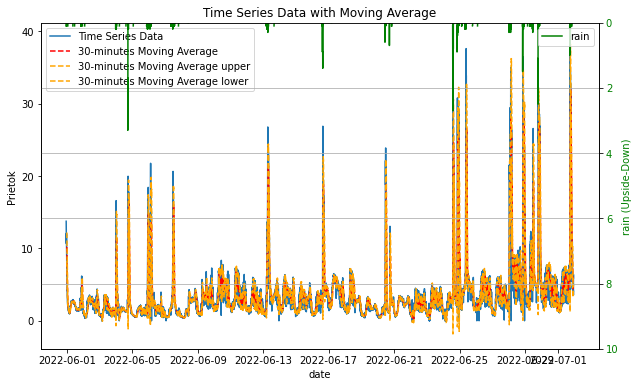

In [145]:
fig, ax1 = plt.subplots(figsize=(10, 6))
ax1.plot(data["date"], data['Prietok'], label='Time Series Data', linestyle='-')
ax1.plot(data["date"], data['Moving_Average'], label=f'{window_size}-minutes Moving Average', linestyle='--', color='red')
ax1.plot(data["date"], data['MA_upper'], label=f'{window_size}-minutes Moving Average upper', linestyle='--', color='orange')
ax1.plot(data["date"], data['MA_lower'], label=f'{window_size}-minutes Moving Average lower', linestyle='--', color='orange')

ax1.set_xlabel('date')
ax1.set_ylabel('Prietok')
ax1.legend()
ax1.set_title('Time Series Data with Moving Average')
ax2 = ax1.twinx()
ax2.set_ylim(0, 10)
ax2.plot(data["date"], data['rain_2m'], label='rain', color='green')
ax2.invert_yaxis()
ax2.set_ylabel('rain (Upside-Down)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

plt.grid(True)
plt.show()

In [133]:
data['day'] = data['date'].dt.date
daily = data.groupby('day')
data['week'] = data['date'].dt.strftime('%Y-%U')
weekly = data.groupby('week')

In [ ]:
for week, group_data in weekly:
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(group_data['date'], group_data['Prietok'])
    ax1.plot(group_data['date'], group_data['Centered_Moving_Average'], color="red")
    ax1.plot(group_data['date'], group_data['CMA_upper'], color="orange")
    ax1.plot(group_data['date'], group_data['CMA_lower'], color="orange")
    ax1.set_title(f'Time Series Data for {week}')
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Prietok')
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 5)
    ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
    ax2.invert_yaxis()
    ax2.set_ylabel('rain (Upside-Down)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [ ]:
for day, group_data in daily:
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(group_data['date'], group_data['Prietok'])
    ax1.plot(group_data['date'], group_data['Centered_Moving_Average'], color="red")
    ax1.plot(group_data['date'], group_data['CMA_upper'], color="orange")
    ax1.plot(group_data['date'], group_data['CMA_lower'], color="orange")
    ax1.set_title(f'Time Series Data for {day}')
    ax1.set_xlabel('Date and Time')
    ax1.set_ylabel('Prietok')
    ax2 = ax1.twinx()
    ax2.set_ylim(0, 5)
    ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
    ax2.invert_yaxis()
    ax2.set_ylabel('rain (Upside-Down)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')
    ax2.legend(loc='upper right')
    plt.grid(True)
    plt.show()

In [301]:
class ts_object:
    
    def __init__(self, data, main_var = "Prietok", 
                 start_date = None, end_date = None, periodicity = "2T", check_per = True):
        if start_date is None:
            start_date = data["date"].min()
        if end_date is None:
            end_date = data["date"].max()
        date_range = pd.date_range(start=start_date, end=end_date, freq=periodicity)
        df = pd.DataFrame({'date': date_range})
        self.data = df.merge(data, on='date', how='left')   # ensuring we have constant periodicity in observations
        if not check_per:
            self.data = data
        self.main_var = main_var
        
    def get_period_data(self, period, start_time = None):
        """Period is either 'daily', 'weekly', or whole number indicating number of hours."""
        if type(period) == int:
            if start_time is None:
                reference_point = data["date"].min()
            else:
                start_time = datetime.strptime(start_time, "%H:%M:%S")
                reference_point = self.data[self.data['date'].dt.time == start_time.time()]["date"].min()
            self.data["period_index"] = self.data["date"].apply(lambda x: (x-reference_point).total_seconds() // (period * 3600))
            self.data["period_name"] = self.data["period_index"].apply(
                lambda x:f"[{reference_point + timedelta(hours=period*x)} -- {reference_point + timedelta(hours=period*(x+1))})")
        
        elif period == "daily":
            self.data['period_name'] = self.data['date'].dt.date
            
        elif period == "weekly":
            first = self.data['date'].dt.strftime('%Y-%W').apply(
                lambda x: x.split("-")).apply(
                lambda y: datetime.strptime(f'{y[0]}-W{y[1]}-1', "%Y-W%U-%w") )
            self.data['period_name'] = first.apply(
                lambda x: f"{x.strftime('%Y-%m-%d')} -- {(x+timedelta(days=6)).strftime('%Y-%m-%d')}")
                       
        else:
            raise NameError('Period which is not recognized have been entered. "weekly" or "daily" are expected.')
        
        self.period_data = self.data.groupby('period_name')
        
    def get_y_lim(self, value):
        if value < 5: return 5
        if value < 10: return 10
        if value < 20: return 20
        return None
        
    def plot(self, variable = None, period = "all", start_time = None, 
             include = ("CMA", "CMA_bounds"), window = 30, rain_lims = (0,5)):
        if variable is None:
            variable = self.main_var
        if "CMA" in include:
            self.data['Centered_Moving_Average'] = self.data[variable].rolling(window=window, center=True).mean()
        if "CeMA_bounds" in include:
            self.data['Centered_Moving_Average'] = self.data[variable].rolling(window=window, center=True).mean()
            self.data['Centered_Moving_SD'] = self.data[variable].rolling(window=window, center=True).std()
            self.data['CMA_upper'] = self.data['Centered_Moving_Average'] + self.data['Centered_Moving_SD']
            self.data['CMA_lower'] = self.data['Centered_Moving_Average'] - self.data['Centered_Moving_SD']
        
        if "MoA" in include:
            self.data['Moving_Average'] = self.data[variable].rolling(window=window, center=False).mean()
        if "MovA_bounds" in include:
            self.data['Moving_Average'] = self.data[variable].rolling(window=window, center=False).mean()
            self.data['Moving_SD'] = self.data[variable].rolling(window=window, center=False).std()
            self.data['MA_upper'] = self.data['Moving_Average'] + self.data['Moving_SD']
            self.data['MA_lower'] = self.data['Moving_Average'] - self.data['Moving_SD']
        
        if period == "all":
            self.data["const"] = "whole data"
            self.period_data = self.data.groupby("const")
        else:
            self.get_period_data(period, start_time)
            
        for unit, group_data in self.period_data:
            fig, ax1 = plt.subplots(figsize=(10, 6))
            ax1.plot(group_data['date'], group_data[variable], label = variable)
            if "CMA" in include:
                ax1.plot(group_data['date'], group_data['Centered_Moving_Average'], color="red", label = "CMA")
            if "CeMA_bounds" in include:
                ax1.plot(group_data['date'], group_data['CMA_upper'], color="orange", label = "CMA_Up")
                ax1.plot(group_data['date'], group_data['CMA_lower'], color="orange", label = "CMA_L")
            if "MoA" in include:
                ax1.plot(group_data['date'], group_data['Moving_Average'], color="red", label = "MA")
            if "MovA_bounds" in include:
                ax1.plot(group_data['date'], group_data['MA_upper'], color="orange", label = "MA_Up")
                ax1.plot(group_data['date'], group_data['MA_lower'], color="orange", label = "MA_L")
            ax1.set_title(f'Time Series for {unit}')
            ax1.set_xlabel('Date and Time')
            ax1.set_ylabel(variable)
            ax1.legend(loc="upper left")
            ylim = self.get_y_lim(group_data[variable].max())
            if ylim is not None: ax1.set_ylim(0, ylim)
            
            ax2 = ax1.twinx()
            ax2.set_ylim(*rain_lims)
            ax2.plot(group_data["date"], group_data['rain_2m'], label='rain', color='green')
            ax2.invert_yaxis()
            ax2.set_ylabel('rain (Upside-Down)', color='green')
            ax2.tick_params(axis='y', labelcolor='green')
            ax2.legend(loc='upper right')
            plt.grid(True)
            plt.show()